In [ ]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
sentimentos = pd.read_csv('/work/data.csv')
sentimentos.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
sentimentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [ ]:
print(f"A base de dados tem {5842} sentenças presentes.")
sentimentos['Sentiment'].value_counts()

A base de dados tem 5842 sentenças presentes.


neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

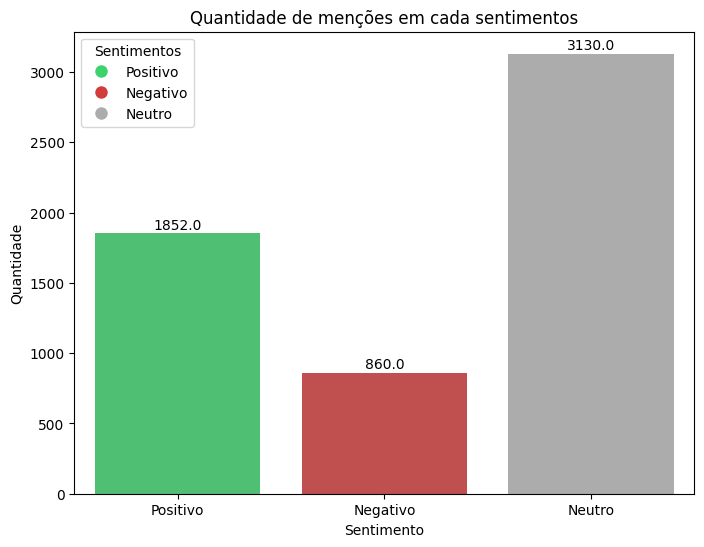

In [ ]:
import matplotlib.pyplot as plt

cores_sentimentos = {'positivo': '#3CD36C', 'negativo': '#D33C3C', 'neutro': '#ACACAC'}

plt.figure(figsize=(8, 6))
grafico = sns.countplot(x='Sentiment', data=sentimentos, palette=cores_sentimentos.values())



plt.title('Quantidade de menções em cada sentimentos', fontsize=12)
plt.xlabel('Sentimento', fontsize=10)
plt.ylabel('Quantidade', fontsize=10)

grafico.set_xticklabels(['Positivo', 'Negativo', 'Neutro'])

legenda = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cores_sentimentos[sentimento], markersize=10, label=sentimento.capitalize()) for sentimento in cores_sentimentos.keys()]
plt.legend(handles=legenda, title='Sentimentos', title_fontsize='10')

for barra in grafico.patches:
    altura = barra.get_height()
    grafico.annotate(f'{altura}', (barra.get_x() + barra.get_width() / 2., altura), ha='center', va='center', xytext=(0, 6), textcoords='offset points', fontsize=10)

plt.show()


In [ ]:

#Aqui é criada uma função para remover as stopwords da língua inglesa,feita a tokenização das sentenças e deixando as palabras em minusculo. Dessa forma eu consigo ter mais informações a respeito da base

#com essas modificações eu crio uma coluna na base de dados e ponho elas no meu dataframe para deixar guardado caso eu precise

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text)
    filtered_words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]
    return filtered_words

# Aplicar pré-processamento aos dados
sentimentos['texto_processado'] = sentimentos['Sentence'].apply(preprocess_text)
sentimentos['qtd_palavras'] = sentimentos['texto_processado'].apply(len)


In [ ]:
sentimentos.head()

,Sentence,Sentiment,texto_processado,qtd_palavras
0,The GeoSolutions technology will leverage Bene...,positive,"[geosolutions, technology, leverage, benefon, ...",21
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"[esi, lows, bk, real, possibility]",5
2,"For the last quarter of 2010 , Componenta 's n...",positive,"[last, quarter, 2010, componenta, net, sales, ...",17
3,According to the Finnish-Russian Chamber of Co...,neutral,"[according, chamber, commerce, major, construc...",9
4,The Swedish buyout firm has sold its remaining...,neutral,"[swedish, buyout, firm, sold, remaining, perce...",14


In [ ]:
#Saber a quantidade média de palavras por sentença
media_palavras = sentimentos['qtd_palavras'].mean()
print(f'A quantidade média de palavras por setenças é de {media_palavras:.2f}, o que representa em média 11 palavras por sentenças.')

A quantidade média de palavras por setenças é de 11.56, o que representa em média 11 palavras por sentenças.


In [ ]:
#Qual a setença que possui a maior quantidade de palavras?
qtd_palavras = list(sentimentos['qtd_palavras'])
maior_frase = max(qtd_palavras)
menor_frase = min(qtd_palavras)

qtd_palavras.index(maior_frase)
qtd_palavras.index(menor_frase)


print(sentimentos[['Sentence','Sentiment']].iloc[qtd_palavras.index(maior_frase)])
print(sentimentos[['Sentence','Sentiment']].iloc[qtd_palavras.index(menor_frase)])

Sentence     Supported Nokia phones include : N96 , N95-8GB...
Sentiment                                              neutral
Name: 3800, dtype: object
Sentence     It 's not .
Sentiment        neutral
Name: 921, dtype: object


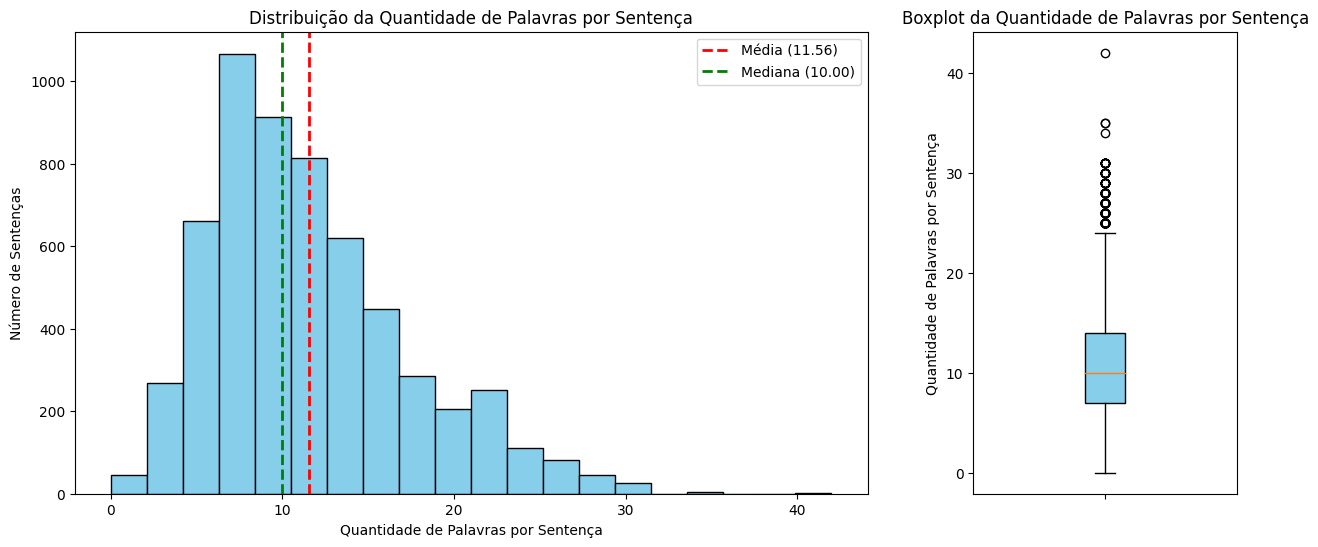

In [ ]:
#Observando a distribuição da quantidade de palavras por sentença de forma agregada

word_count_column = 'qtd_palavras'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

# Plotagem do histograma
ax1.hist(sentimentos[word_count_column], bins=20, color='skyblue', edgecolor='black')
ax1.set_xlabel('Quantidade de Palavras por Sentença')
ax1.set_ylabel('Número de Sentenças')
ax1.set_title('Distribuição da Quantidade de Palavras por Sentença')


mean_value = sentimentos[word_count_column].mean()
median_value = sentimentos[word_count_column].median()
ax1.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Média ({mean_value:.2f})')
ax1.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Mediana ({median_value:.2f})')
ax1.legend()

# Plotagem do boxplot
boxplot = ax2.boxplot(sentimentos[word_count_column], vert=True, patch_artist=True)
for patch in boxplot['boxes']:
    patch.set_facecolor('skyblue')
ax2.set_xticklabels('')
ax2.set_ylabel('Quantidade de Palavras por Sentença')
ax2.set_title('Boxplot da Quantidade de Palavras por Sentença')

plt.show()

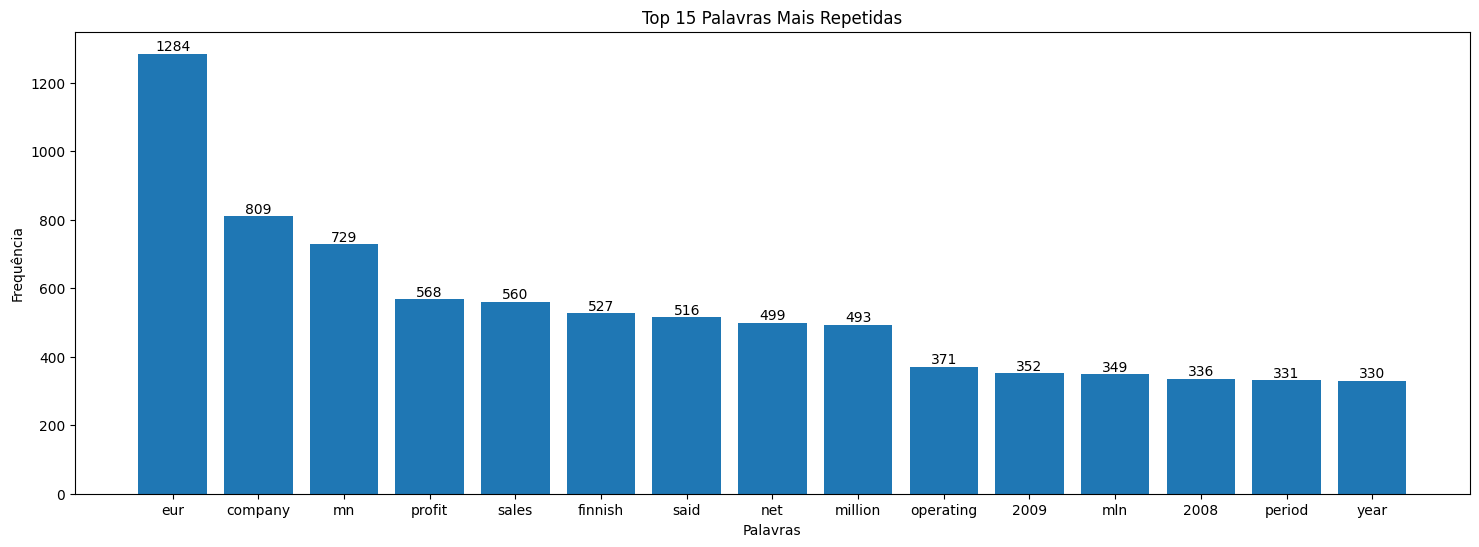

In [ ]:
#Gráfico de barras para saber as 15 palavras que mais apareceram

def plot_most_common_words(df, column_name, num_words=10):
    # Tokenização e contagem de palavras
    all_words = [word.lower() for words in df[column_name] for word in words]
    freq_dist = FreqDist(all_words)
    
    # Seleção das palavras mais comuns
    most_common_words = freq_dist.most_common(num_words)
    
    # Plotagem do gráfico
    plt.figure(figsize=(18, 6))
    bars = plt.bar(*zip(*most_common_words))
    
    # Adicionar rótulos às barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), ha='center', va='bottom')
    
    plt.xlabel('Palavras')
    plt.ylabel('Frequência')
    plt.title(f'Top {num_words} Palavras Mais Repetidas')
    plt.show()

# Exemplo de uso
plot_most_common_words(sentimentos, 'texto_processado', num_words=15)

In [ ]:
sia = SentimentIntensityAnalyzer()
sentimentos['sentiment_score'] = sentimentos['Sentence'].apply(lambda x: sia.polarity_scores(x)['compound'])
print("Média de pontuação de sentimento:", sentimentos['sentiment_score'].mean())

Média de pontuação de sentimento: 0.15049840807942486


In [ ]:
sentimentos.head()

,Sentence,Sentiment,texto_processado,qtd_palavras,sentiment_score
0,The GeoSolutions technology will leverage Bene...,positive,"[geosolutions, technology, leverage, benefon, ...",21,0.5423
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"[esi, lows, bk, real, possibility]",5,-0.2023
2,"For the last quarter of 2010 , Componenta 's n...",positive,"[last, quarter, 2010, componenta, net, sales, ...",17,0.1531
3,According to the Finnish-Russian Chamber of Co...,neutral,"[according, chamber, commerce, major, construc...",9,0.0000
4,The Swedish buyout firm has sold its remaining...,neutral,"[swedish, buyout, firm, sold, remaining, perce...",14,0.0000


In [ ]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')


#É aplicada a lematização para verificar se quando aplicarmos o modelo fica melhor, mas depois não teve muitas mudanças

def preprocess_dataframe(df, text_column, new_column_name='preprocessed_text'):
 
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))


    df[new_column_name] = df[text_column].apply(lambda sentence: ' '.join([lemmatizer.lemmatize(word.lower()) for word in word_tokenize(sentence) if word.isalnum() and word.lower() not in stop_words]))

    return df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
sentimentos2 = preprocess_dataframe(sentimentos,'Sentence','texto_processado2')
sentimentos2.head()

,Sentence,Sentiment,texto_processado,qtd_palavras,sentiment_score,texto_processado2
0,The GeoSolutions technology will leverage Bene...,positive,"[geosolutions, technology, leverage, benefon, ...",21,0.5423,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"[esi, lows, bk, real, possibility]",5,-0.2023,esi low bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,"[last, quarter, 2010, componenta, net, sales, ...",17,0.1531,last quarter 2010 componenta net sale doubled ...
3,According to the Finnish-Russian Chamber of Co...,neutral,"[according, chamber, commerce, major, construc...",9,0.0000,according chamber commerce major construction ...
4,The Swedish buyout firm has sold its remaining...,neutral,"[swedish, buyout, firm, sold, remaining, perce...",14,0.0000,swedish buyout firm sold remaining percent sta...


In [ ]:
#Agora usando 8 algoritmos para ver qual o melhor que pode contribuir 
X_train, X_test, y_train, y_test = train_test_split(sentimentos2['texto_processado2'], sentimentos2['Sentiment'], test_size=0.3,random_state=42)

# Vetorização usando TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_features = vectorizer.fit_transform(X_train)

# Criação dos modelos
models = {
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Ridge Classifier': RidgeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Avaliação de cada modelo usando validação cruzada
model_accuracies = {}
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_features, y_train, cv=5, scoring=make_scorer(accuracy_score))
    model_accuracies[model_name] = cv_scores.mean()
    print(f'{model_name}: Acurácia média na validação cruzada: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

# Escolhe o modelo com a maior acurácia média na validação cruzada
best_model = max(model_accuracies, key=model_accuracies.get)
best_model_instance = models[best_model]

# Exibe as acurácias de cada modelo
print("\nAcurácias de cada modelo:")
for model_name, accuracy in model_accuracies.items():
    print(f'{model_name}: {accuracy:.2f}')


Naive Bayes: Acurácia média na validação cruzada: 0.66 (+/- 0.01)
Support Vector Machine: Acurácia média na validação cruzada: 0.65 (+/- 0.02)
Random Forest: Acurácia média na validação cruzada: 0.64 (+/- 0.04)
Gradient Boosting: Acurácia média na validação cruzada: 0.65 (+/- 0.01)
Logistic Regression: Acurácia média na validação cruzada: 0.67 (+/- 0.02)
Ridge Classifier: Acurácia média na validação cruzada: 0.67 (+/- 0.01)
K-Nearest Neighbors: Acurácia média na validação cruzada: 0.61 (+/- 0.01)
Decision Tree: Acurácia média na validação cruzada: 0.59 (+/- 0.03)

Acurácias de cada modelo:
Naive Bayes: 0.66
Support Vector Machine: 0.65
Random Forest: 0.64
Gradient Boosting: 0.65
Logistic Regression: 0.67
Ridge Classifier: 0.67
K-Nearest Neighbors: 0.61
Decision Tree: 0.59


In [ ]:
best_model_instance.fit(X_train_features, y_train)
X_test_features = vectorizer.transform(X_test)
predictions = best_model_instance.predict(X_test_features)
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
classification_rep = classification_report(y_test, predictions)


print(f'\nMelhor modelo: {best_model}')
print(f'Acurácia nos dados de teste: {accuracy:.2f}')
print('Matriz de Confusão:')
print(conf_matrix)
print('Relatório de Classificação:')
print(classification_rep)


Melhor modelo: Logistic Regression
Acurácia nos dados de teste: 0.69
Matriz de Confusão:
[[ 43 171  55]
 [ 30 834  61]
 [ 11 207 341]]
Relatório de Classificação:
              precision    recall  f1-score   support

    negative       0.51      0.16      0.24       269
     neutral       0.69      0.90      0.78       925
    positive       0.75      0.61      0.67       559

    accuracy                           0.69      1753
   macro avg       0.65      0.56      0.57      1753
weighted avg       0.68      0.69      0.66      1753



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sentimentos2['texto_processado2'], sentimentos2['Sentiment'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_features = vectorizer.fit_transform(X_train)

logistic_regression_model = LogisticRegression(class_weight='balanced',solver='newton-cg',multi_class = 'multinomial')

logistic_regression_model.fit(X_train_features, y_train)


X_test_features = vectorizer.transform(X_test)

predictions = logistic_regression_model.predict(X_test_features)



feature_names = vectorizer.get_feature_names_out()
coeficients_per_class = logistic_regression_model.coef_

coef_dfs = []
for i, class_coeficients in enumerate(coeficients_per_class):
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': class_coeficients})
    coef_df['Class'] = f'Class_{i}'
    coef_dfs.append(coef_df)

final_coef_df = pd.concat(coef_dfs)


sorted_coef_df = final_coef_df.sort_values(by='Coefficient', ascending=False)
sorted_coef_df.head(10)

,Feature,Coefficient,Class
3487,rose,3.852821,Class_2
1068,decreased,3.465378,Class_0
2290,lower,2.892321,Class_0
1930,increase,2.839495,Class_2
1931,increased,2.704598,Class_2
2274,long,2.624659,Class_2
663,buy,2.571224,Class_2
1744,grew,2.559375,Class_2
1525,fell,2.540500,Class_0
1494,fall,2.454586,Class_0


Classification Report:
              precision    recall  f1-score   support

    negative       0.58      0.96      0.73       685
     neutral       0.95      0.79      0.86      2508
    positive       0.91      0.88      0.90      1480

    accuracy                           0.85      4673
   macro avg       0.81      0.88      0.83      4673
weighted avg       0.88      0.85      0.85      4673


Accuracy: 0.85


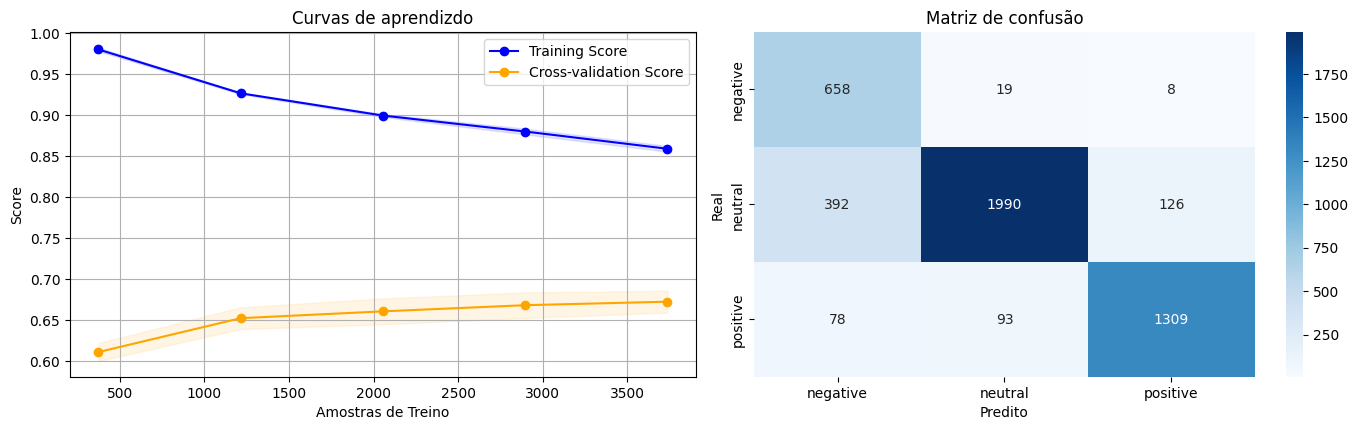

In [ ]:
def plot_learning_curve_with_metrics(estimator, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
  
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure(figsize=(14, 8))


    plt.subplot(2, 2, 1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training Score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="orange", label="Cross-validation Score")

    plt.title("Curvas de aprendizdo")
    plt.xlabel("Amostras de Treino")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(True)

    
    plt.subplot(2, 2, 2)

    
    estimator.fit(X, y)

    
    y_pred = estimator.predict(X)

   
    print("Classification Report:")
    print(classification_report(y, y_pred))

    conf_matrix = confusion_matrix(y, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title("Matriz de confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")

    accuracy = accuracy_score(y, y_pred)
    print(f"\nAccuracy: {accuracy:.2f}")

    plt.tight_layout()
    plt.show()


X_train, X_test, y_train, y_test = train_test_split(sentimentos2['texto_processado2'], sentimentos2['Sentiment'], test_size=0.2, random_state=42)


vectorizer = TfidfVectorizer(max_features=5000)
X_train_features = vectorizer.fit_transform(X_train)

plot_learning_curve_with_metrics(logistic_regression_model, X_train_features, y_train, cv=5, scoring='accuracy')


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ef73d612-bd8d-4eca-82d3-86bec2548c9e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>